### Preparing the data:

In [ ]:
from google.colab import drive
drive._mount('/content/')
# !tar -xzvf "/content/gdrive/MyDrive/cars_train.tgz" -C "/content/gdrive/MyDrive/decompressed/trainset"

ValueError: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

### Import Modules:

In [ ]:
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.layers as tkl
import tensorflow as tf
from keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Input, Conv2D, UpSampling2D, BatchNormalization, Activation, Add, ZeroPadding2D, concatenate
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import cv2
from sklearn.model_selection import train_test_split
from skimage.util import random_noise
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import glob
import random
from itertools import chain

### Creating a list of file names:

In [ ]:
source_path = '/content/gdrive/MyDrive/HighResolution/'

filenames = []
folder_names = ['62000', '63000', '64000', '65000', '66000', '67000', '68000', '69000']
# test = os.path.join(source_path, f'{folder_names[1]}')
# content = os.listdir(test)

# print(content)
for folder in folder_names:
  
    filenames.append(glob.glob(os.path.join(source_path, f'{folder}/*.png')))

filenames = list(chain.from_iterable(filenames))
random.shuffle(filenames)
print('Completed.')

Completed.


### Length of filenames:

In [ ]:
print(len(filenames))

8000


### Showing a sample:

/content/gdrive/MyDrive/HighResolution/65000/65115.png


Text(0.5, 1.0, 'Noisy')

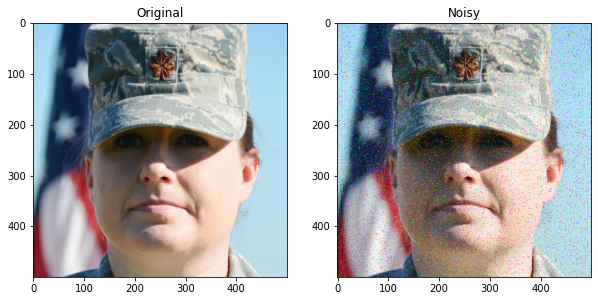

In [ ]:
img_path = filenames[1001]
print(img_path)
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (500, 500))
noisy = random_noise(img, mode = 's&p', amount=0.05)
fig, ax = plt.subplots(1, 2, figsize = (10,12))
ax[0].imshow(img)
ax[0].set_title('Original')
ax[1].imshow(noisy)
ax[1].set_title('Noisy')

### Creating train set and test set:

In [ ]:
test_filenames = filenames[-2001:-1]
del filenames[-2001:-1]
train_filenames = filenames
print(f'Size of training set is: {len(train_filenames)}', end='\n----------------------------\n')
print(f'Size of test set is: {len(test_filenames)}', end='\n----------------------------\n')

Size of training set is: 6000
----------------------------
Size of test set is: 2000
----------------------------


### Train set and validation set:

In [ ]:
train_img, val_img, _, _ = train_test_split(train_filenames, train_filenames, test_size = 0.2, shuffle = True, random_state = 0)

In [ ]:
print(f'Size of training set is: {len(train_img)}', end='\n----------------------------\n')
print(f'Size of validation set is: {len(val_img)}', end='\n----------------------------\n')
print(f'Total: {len(train_img) + len(val_img)}')

Size of training set is: 4800
----------------------------
Size of validation set is: 1200
----------------------------
Total: 6000


### Determining important variables:

In [ ]:
WIDTH = 256
HEIGHT = 256
n_channels = 3
BATCH_SIZE = 32

### Data generation:

In [ ]:
class  DataGenerator(tf.keras.utils.Sequence):
    
    def __init__(self, orig_filenames, batch_size = 32, shuffle = True):
        self.orig_filenames = orig_filenames
        self.noisy_filenames = orig_filenames
        self.filenames = list(zip(self.orig_filenames, self.noisy_filenames))
        self.batch_size = BATCH_SIZE
        self.shuffle = shuffle
    
    def __len__(self):
        return (len(self.orig_filenames) // self.batch_size)
    
    def __getitem__(self, idx):
        batch = self.filenames[idx * self.batch_size : (idx + 1) * self.batch_size]
        X, Y = self.__data_generation(batch)

        return X, Y
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.orig_filenames))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def __data_generation(self, batch):
        orig = []
        noisy = []
        
        for orig_file, _ in batch:
          image = cv2.imread(orig_file)
          image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
          image = cv2.resize(image, (WIDTH, HEIGHT))
          orig.append(image)
          noisy.append(self.make_noisy(image))
          
        return  np.array(noisy), np.array(orig)

    def make_noisy(self, image):
      image_ = image
      noisy_image = random_noise(image_, mode = 's&p', amount=0.05)
      
      return noisy_image

### Generating training set and validation set:

In [ ]:
train_generator = DataGenerator(train_img[1000], BATCH_SIZE)
val_generator = DataGenerator(val_img[1000], BATCH_SIZE)

### Creating the model architecture (U-net):

In [ ]:
def identical_block(X, n_filters, kernel_size):
  print('Identical def is started ')
  x_shortcut = X
  
  '''first part of identify block: '''

  res_block = Conv2D(filters = n_filters, 
               kernel_size = kernel_size, padding = 'same')(X)
  res_block = BatchNormalization()(res_block)
  res_block = Activation('relu')(res_block)
  
  '''Second part of identify block: '''

  res_block = Conv2D(filters = n_filters, 
               kernel_size = kernel_size, padding = 'same')(res_block)
  res_block = BatchNormalization()(res_block)
  
  ''' skip part: '''

  res_block = Add()([res_block, x_shortcut])
  # res_block = Activation('relu')
  print('------------------- Identical def is ended ')
  return res_block


# def conv_block(inputs, n_filters = 64, kernel_size = (3,3)):
  
#   conv = tkl.Conv2D(n_filters, kernel_size)(inputs)
#   conv = tkl.BatchNormalization()(conv)
#   conv = tkl.Activation('relu')(conv)
#   conv = tkl.Conv2D(n_filters, kernel_size)(conv)
#   conv = tkl.BatchNormalization()(conv)

#   return conv


def encoder(input, skip, n_filters, kernel_size):
  print('Encoder def is started ')
  input = input
  
  pix_shuffle = tf.nn.depth_to_space(input, 2, data_format='NHWC')
  stacked = tkl.concatenate([skip, pix_shuffle])
  

  enc_block = BatchNormalization()(stacked)
  enc_block = Conv2D(filters=n_filters, kernel_size=kernel_size)(enc_block)
  enc_block = Activation('relu')(enc_block)
  enc_block = Conv2D(filters=n_filters, kernel_size=kernel_size)(enc_block)
  enc_block = Activation('relu')(enc_block)
  # enc_block = Activation('relu')(enc_block)
  print('+++++++++++++++++++++ Encoder def is ended ')
  return enc_block


def r_unet():

  print('runet is started [Contraction path]')
  ''' Contraction path (Encoder): '''

  input_shape = (WIDTH, HEIGHT, n_channels)
  input_img = tf.keras.Input(input_shape, name = 'image')

  first_conv = Conv2D(filters=64, kernel_size=(3,3))(input_img)
  first_conv = BatchNormalization()(first_conv)
  first_conv = Activation('relu')(first_conv)
  skip0 = first_conv
  skip0 = Conv2D(32, (151,151))(skip0)
  out0 = MaxPooling2D()(first_conv)
  print(f' first conv is: {out0}')

  res_block = identical_block(out0, 64, (3,3))
  res_block = identical_block(res_block, 64, (3,3))
  res_block = identical_block(res_block, 64, (3,3))
  print(f'res_block is printed: {res_block}')
  conv = Conv2D(128, (3,3))(res_block)
  res_block = identical_block(conv, 128, (3,3))
  skip1 = res_block
  skip1 = Conv2D(32, (70,70))(skip1)
  print(f'skip1 is printed: {skip1}')
  out1 = MaxPooling2D()(res_block)
  print(f'out1 is printed: {out1}')
  
  res_block = identical_block(out1, 128, (3,3))
  res_block = identical_block(res_block, 128, (3,3))
  res_block = identical_block(res_block, 128, (3,3))
  conv = Conv2D(256, (3,3))(res_block)
  res_block = identical_block(conv, 256, (3,3))
  skip2 = res_block
  skip2 = Conv2D(128, (29,29))(skip2)
  print(f'skip2 is printed: {skip2}')
  out2 = MaxPooling2D()(res_block)
  print(f'out2 is printed: {out2}')

  res_block = identical_block(out2, 256, (3,3))
  res_block = identical_block(res_block, 256, (3,3))
  res_block = identical_block(res_block, 256, (3,3))
  res_block = identical_block(res_block, 256, (3,3))
  res_block = identical_block(res_block, 256, (3,3))
  conv = Conv2D(512, (3,3))(res_block)
  res_block = identical_block(conv, 512, (3,3))
  skip3 = res_block
  skip3 = Conv2D(128, (9,9))(skip3)
  print(f'skip3 is printed: {skip3}')
  out3 = MaxPooling2D()(res_block)
  print(f'out3 is printed: {out3}')

  res_block = identical_block(out3, 512, (3,3))
  res_block = identical_block(res_block, 512, (3,3))
  conv = BatchNormalization()(res_block)
  conv = Activation('relu')(conv)
  skip4 = conv
  skip4 = Conv2D(128,(1,1))(skip4)
  print(f'skip4 is printed: {skip4}')
  
  conv = Conv2D(1024, (1,1))(conv)
  conv = Activation('relu')(conv)
  conv = Conv2D(512, (8,8))(conv)
  conv = Activation('relu')(conv)
  print(f'conv is printed: {conv}')
  print('*********************** [Contraction path] runet is ended ')

  ''' Expansion path (Decoder): '''

  print('[Expansion path] runet is started ')

  enc_block = encoder(conv, skip4, 512, (3,3))
  print(f'@^@^@ 1st step of encoder: {enc_block}')
  enc_block = encoder(enc_block, skip3, 256, (3,3))
  print(f'@^@^@ 2nd step of encoder: {enc_block}')
  enc_block = encoder(enc_block, skip2, 128, (3,3))
  print(f'@^@^@ 3rd step of encoder: {enc_block}') 
  enc_block = encoder(enc_block, skip1, 128, (3,3))
  print(f'@^@^@ last step of encoder: {enc_block}')
  

# def encoder(input, skip, n_filters, kernel_size):
#   input = input
  
#   pix_shuffle = tf.nn.depth_to_space(input, 2, data_format='NHWC')
#   stacked = tf.stack([skip, pix_shuffle])

#   enc_block = BatchNormalization()(stacked)
#   enc_block = Conv2D(filters=n_filters, kernel_size=kernel_size)(enc_block)
#   enc_block = Activation('relu')(enc_block)
#   enc_block = Conv2D(filters=n_filters, kernel_size=kernel_size)(enc_block)
#   enc_block = Activation('relu')(enc_block)
#   # enc_block = Activation('relu')(enc_block)

#   return enc_block



  enc_block = tf.nn.depth_to_space(enc_block, 2, data_format='NHWC')
  stacked = tkl.concatenate([skip0, enc_block])

  last_conv = Conv2D(64, (1,1))(stacked)
  last_conv = Activation('relu')(last_conv)
  last_conv = Conv2D(32, (1,1))(stacked)
  last_conv = Activation('relu')(last_conv)
  output = Conv2D(3, (1,1), activation='sigmoid')(last_conv)
  print('======================= [Expansion path] runet is ended ')
  print(f' Output is: {output}')
  model = tf.keras.Model(inputs = [input_img], outputs = [output])

  return model

  

In [ ]:
model = r_unet()
# model.summary()

In [ ]:
model.summary()

In [ ]:
def resnet(input, n_filters, kernel_size, padding, stride, ):
    pad = ZeroPadding2D((3,3))(input)
    conv = Conv2D(64, (7,7), strides=2)(pad)
    conv = BatchNormalization()(conv)
    conv = ZeroPadding2D((1,1))(conv)
    skip0 = conv
    out0 = MaxPooling2D(pool_size=(3,3), strides=2)(conv)   # 256,256,64

    # -------

    # block1:
    conv = ZeroPadding2D((1,1))(out0)
    conv = Conv2D(64, (3,3), strides=1)(conv)
    conv = BatchNormalization()(conv)
    conv = Activation('relu')(conv)
    conv = ZeroPadding2D((1,1))(conv)
    conv = Conv2D(64, (3,3), strides=1)(conv)
    conv = BatchNormalization()(conv)
    out1 = Add()([conv, out0])

    conv = ZeroPadding2D((1,1))(out1)
    conv = Conv2D(64, (3,3), strides=1)(conv)
    conv = BatchNormalization()(conv)
    conv = Activation('relu')(conv)
    conv = ZeroPadding2D((1,1))(conv)
    conv = Conv2D(64, (3,3), strides=1)(conv)
    conv = BatchNormalization()(conv)
    out2 = Add()([conv, out1])

    conv = ZeroPadding2D((1,1))(out2)
    conv = Conv2D(64, (3,3), strides=1)(conv)
    conv = BatchNormalization()(conv)
    conv = Activation('relu')(conv)
    conv = ZeroPadding2D((1,1))(conv)
    conv = Conv2D(64, (3,3), strides=1)(conv)
    conv = BatchNormalization()(conv)

    out3 = Add()([conv, out2])    # 256,256,64

  # block2

    conv = ZeroPadding2D((1,1))(out3)
    conv = Conv2D(128, (3,3), strides=2)(conv)
    conv = BatchNormalization()(conv)
    conv = Activation('relu')(conv)
    conv = ZeroPadding((1,1))(conv)
    conv = Conv2D(128, (3,3), strides=1)(conv)
    conv = BatchNormalization()(conv)
    temp_out = Conv2D(128, (1,1), strides=2)(out3)
    out = Add()([conv, temp_out]) # 128,128,128
    skip = out
    out4 = MaxPooling2D(pool_size=(2,2), strides=2)(out) #64,64,128

    conv = ZeroPadding2D((1,1))(out4)
    conv = Conv2D(128, (3,3), strides=1)(conv)
    conv = BatchNormalization()(conv)
    conv = Activation('relu')(conv)
    conv = ZeroPadding2D((1,1))(conv)
    conv = Conv2D(128, (3,3), strides=1)(conv)
    conv = BatchNormalization()(conv) # 64,64,128
    out5 = Add()([conv, out4])

    conv = ZeroPadding2D((1,1))(out5)
    conv = Conv2D(128, (3,3), strides=1)(conv)
    conv = BatchNormalization()(conv)
    conv = Activation('relu')(conv)
    conv = ZeroPadding2D((1,1))(conv)
    conv = Conv2D(128, (3,3), strides=1)(conv)
    conv = BatchNormalization()(conv) # 64,64,128
    out6 = Add()([conv, out5])
    
    conv = ZeroPadding2D((1,1))(out5)
    conv = Conv2D(128, (3,3), strides=1)(conv)
    conv = BatchNormalization()(conv)
    conv = Activation('relu')(conv)
    conv = ZeroPadding2D((1,1))(conv)
    conv = Conv2D(128, (3,3), strides=1)(conv)
    conv = BatchNormalization()(conv) # 64,64,128
    out7 = Add()([conv, out6])

    # block3

    conv = ZeroPadding2D((1,1))(out7)
    conv = Conv2D(256, (3,3), strides=2)(conv)  # 32,32,256
    conv = BatchNormalization()(conv)
    conv = Activation('relu')(conv)
    conv = ZeroPadding((1,1))(conv)
    conv = Conv2D(256, (3,3), strides=1)(conv)
    conv = BatchNormalization()(conv)
    temp_out = Conv2D(256, (1,1), strides=2)(out7)
    out = Add()([conv, temp_out]) # 32,32,256
    skip = out
    out8 = MaxPooling2D(pool_size=(2,2), strides=2)(out) # 32,32,256

   # 1
    conv = ZeroPadding2D((1,1))(out8)
    conv = Conv2D(256, (3,3), strides=1)(conv)
    conv = BatchNormalization()(conv)
    conv = Activation('relu')(conv)
    conv = ZeroPadding2D((1,1))(conv)
    conv = Conv2D(256, (3,3), strides=1)(conv)
    conv = BatchNormalization()(conv) # 32,32,256
    out9 = Add()([conv, out8]) 

    conv = ZeroPadding2D((1,1))(out9)
    conv = Conv2D(256, (3,3), strides=1)(conv)
    conv = BatchNormalization()(conv)
    conv = Activation('relu')(conv)
    conv = ZeroPadding2D((1,1))(conv)
    conv = Conv2D(256, (3,3), strides=1)(conv)
    conv = BatchNormalization()(conv) # 32,32,256
    out10 = Add()([conv, out9]) 

    conv = ZeroPadding2D((1,1))(out10)
    conv = Conv2D(256, (3,3), strides=1)(conv)
    conv = BatchNormalization()(conv)
    conv = Activation('relu')(conv)
    conv = ZeroPadding2D((1,1))(conv)
    conv = Conv2D(256, (3,3), strides=1)(conv)
    conv = BatchNormalization()(conv) # 32,32,256
    out11 = Add()([conv, out10]) 

    conv = ZeroPadding2D((1,1))(out11)
    conv = Conv2D(256, (3,3), strides=1)(conv)
    conv = BatchNormalization()(conv)
    conv = Activation('relu')(conv)
    conv = ZeroPadding2D((1,1))(conv)
    conv = Conv2D(256, (3,3), strides=1)(conv)
    conv = BatchNormalization()(conv) # 32,32,256
    out12 = Add()([conv, out11]) 

    conv = ZeroPadding2D((1,1))(out12)
    conv = Conv2D(256, (3,3), strides=1)(conv)
    conv = BatchNormalization()(conv)
    conv = Activation('relu')(conv)
    conv = ZeroPadding2D((1,1))(conv)
    conv = Conv2D(256, (3,3), strides=1)(conv)
    conv = BatchNormalization()(conv) # 32,32,256
    out13 = Add()([conv, out12]) 

    # block4

    conv = ZeroPadding2D((1,1))(out13)
    conv = Conv2D(512, (3,3), strides=2)(conv)  # 16,16,512
    conv = BatchNormalization()(conv)
    conv = Activation('relu')(conv)
    conv = ZeroPadding((1,1))(conv)
    conv = Conv2D(512, (3,3), strides=1)(conv)
    conv = BatchNormalization()(conv)
    temp_out = Conv2D(512, (1,1), strides=2)(out13)
    out = Add()([conv, temp_out]) # 16,16,512
    skip = out
    out14 = MaxPooling2D(pool_size=(2,2), strides=2)(out) # 16,16,512


    conv = ZeroPadding2D((1,1))(out14)
    conv = Conv2D(512, (3,3), strides=1)(conv)
    conv = BatchNormalization()(conv)
    conv = Activation('relu')(conv)
    conv = ZeroPadding2D((1,1))(conv)
    conv = Conv2D(512, (3,3), strides=1)(conv)
    conv = BatchNormalization()(conv) # 16,16,512
    out15 = Add()([conv, out14]) 

    conv = ZeroPadding2D((1,1))(out15)
    conv = Conv2D(256, (3,3), strides=1)(conv)
    conv = BatchNormalization()(conv)
    conv = Activation('relu')(conv)
    conv = ZeroPadding2D((1,1))(conv)
    conv = Conv2D(256, (3,3), strides=1)(conv)
    conv = BatchNormalization()(conv) # 16,16,512
    out16 = Add()([conv, out15]) 

    conv = BatchNormalization()(out16)
    conv = Activation('relu') # 16,16,512

    conv = ZeroPadding2D((1,1))(conv)
    conv = Conv2d(1024, (3,3), strides=2)(conv) # 8,8,1024
    conv = Activation('relu') # 8,8,1024




In [ ]:
# def resnet(input, n_filters, kernel_size, padding, stride, ):
input_shape = (1024, 1024, 3)
input_img = Input(input_shape)

pad = ZeroPadding2D((3,3))(input_img)
conv = Conv2D(64, (7,7), strides=2)(pad)  # 512,512,64
skip0 = conv
# print(f'Skip0 dimensions is: {skip0}')
conv = BatchNormalization()(conv)
conv = ZeroPadding2D((1,1))(conv)
out0 = MaxPooling2D(pool_size=(3,3), strides=2)(conv)   # 256,256,64
  # -------
  # block1:
conv = ZeroPadding2D((1,1))(out0)
conv = Conv2D(64, (3,3), strides=1)(conv)
conv = BatchNormalization()(conv)
conv = Activation('relu')(conv)
conv = ZeroPadding2D((1,1))(conv)
conv = Conv2D(64, (3,3), strides=1)(conv)
conv = BatchNormalization()(conv)
out1 = Add()([conv, out0])
conv = ZeroPadding2D((1,1))(out1)
conv = Conv2D(64, (3,3), strides=1)(conv)
conv = BatchNormalization()(conv)
conv = Activation('relu')(conv)
conv = ZeroPadding2D((1,1))(conv)
conv = Conv2D(64, (3,3), strides=1)(conv)
conv = BatchNormalization()(conv)
out2 = Add()([conv, out1])
conv = ZeroPadding2D((1,1))(out2)
conv = Conv2D(64, (3,3), strides=1)(conv)
conv = BatchNormalization()(conv)
conv = Activation('relu')(conv)
conv = ZeroPadding2D((1,1))(conv)
conv = Conv2D(64, (3,3), strides=1)(conv)
conv = BatchNormalization()(conv) 
out3 = Add()([conv, out2])    # 256,256,64

  #block2
conv = ZeroPadding2D((1,1))(out3)
conv = Conv2D(128, (3,3), strides=2)(conv)
conv = BatchNormalization()(conv)
conv = Activation('relu')(conv)
conv = ZeroPadding2D((1,1))(conv)
conv = Conv2D(128, (3,3), strides=1)(conv)
conv = BatchNormalization()(conv)
temp_out = Conv2D(128, (1,1), strides=2)(out3)
out = Add()([conv, temp_out]) # 128,128,128
skip1 = out
# print(f'Skip1 dimensions is: {skip1}')

out4 = MaxPooling2D(pool_size=(2,2), strides=2)(out) #64,64,128
conv = ZeroPadding2D((1,1))(out4)
conv = Conv2D(128, (3,3), strides=1)(conv)
conv = BatchNormalization()(conv)
conv = Activation('relu')(conv)
conv = ZeroPadding2D((1,1))(conv)
conv = Conv2D(128, (3,3), strides=1)(conv)
conv = BatchNormalization()(conv) # 64,64,128
out5 = Add()([conv, out4])

conv = ZeroPadding2D((1,1))(out5)
conv = Conv2D(128, (3,3), strides=1)(conv)
conv = BatchNormalization()(conv)
conv = Activation('relu')(conv)
conv = ZeroPadding2D((1,1))(conv)
conv = Conv2D(128, (3,3), strides=1)(conv)
conv = BatchNormalization()(conv) # 64,64,128
out6 = Add()([conv, out5])
  
conv = ZeroPadding2D((1,1))(out6)
conv = Conv2D(128, (3,3), strides=1)(conv)
conv = BatchNormalization()(conv)
conv = Activation('relu')(conv)
conv = ZeroPadding2D((1,1))(conv)
conv = Conv2D(128, (3,3), strides=1)(conv)
conv = BatchNormalization()(conv) # 64,64,128
out7 = Add()([conv, out6])
# block3
conv = ZeroPadding2D((1,1))(out7)
conv = Conv2D(256, (3,3), strides=2)(conv)  # 32,32,256
conv = BatchNormalization()(conv)
conv = Activation('relu')(conv)
conv = ZeroPadding2D((1,1))(conv)
conv = Conv2D(256, (3,3), strides=1)(conv)
conv = BatchNormalization()(conv)
temp_out = Conv2D(256, (1,1), strides=2)(out7)
out = Add()([conv, temp_out]) # 32,32,256
skip2 = out
# print(f'Skip2 dimensions is: {skip2}')
out8 = MaxPooling2D(pool_size=(2,2), strides=2)(out) # 16,16,256
# print(f'out8 dimensions is: {out8}')  
  #1
conv = ZeroPadding2D((1,1))(out8)
conv = Conv2D(256, (3,3), strides=1)(conv)
conv = BatchNormalization()(conv)
conv = Activation('relu')(conv)
conv = ZeroPadding2D((1,1))(conv)
conv = Conv2D(256, (3,3), strides=1)(conv)
conv = BatchNormalization()(conv) #16,16,256
# print(f'conv below out8 dimensions is: {conv}')  
out9 = Add()([conv, out8]) 
# print(f'out9 dimensions is: {out9}')  

conv = ZeroPadding2D((1,1))(out9)
conv = Conv2D(256, (3,3), strides=1)(conv)
conv = BatchNormalization()(conv)
conv = Activation('relu')(conv)
conv = ZeroPadding2D((1,1))(conv)
conv = Conv2D(256, (3,3), strides=1)(conv)
conv = BatchNormalization()(conv) #16,16,256
out10 = Add()([conv, out9]) 

conv = ZeroPadding2D((1,1))(out10)
conv = Conv2D(256, (3,3), strides=1)(conv)
conv = BatchNormalization()(conv)
conv = Activation('relu')(conv)
conv = ZeroPadding2D((1,1))(conv)
conv = Conv2D(256, (3,3), strides=1)(conv)
conv = BatchNormalization()(conv) #16,16,256
out11 = Add()([conv, out10]) 

conv = ZeroPadding2D((1,1))(out11)
conv = Conv2D(256, (3,3), strides=1)(conv)
conv = BatchNormalization()(conv)
conv = Activation('relu')(conv)
conv = ZeroPadding2D((1,1))(conv)
conv = Conv2D(256, (3,3), strides=1)(conv)
conv = BatchNormalization()(conv) #16,16,256
out12 = Add()([conv, out11]) 
# print(f'out12 dimensions is: {out12}')
conv = ZeroPadding2D((1,1))(out12)
conv = Conv2D(256, (3,3), strides=1)(conv)
conv = BatchNormalization()(conv)
conv = Activation('relu')(conv)
conv = ZeroPadding2D((1,1))(conv)
conv = Conv2D(256, (3,3), strides=1)(conv)
conv = BatchNormalization()(conv) #16,16,256
out13 = Add()([conv, out12]) 
# print(f'out13 dimensions is: {out13}')


# block4
conv = ZeroPadding2D((1,1))(out13)
conv = Conv2D(512, (3,3), strides=2)(conv)  # 8,8,512
# print(f'conv dimensions is: {conv}')
conv = BatchNormalization()(conv)
conv = Activation('relu')(conv)
conv = ZeroPadding2D((1,1))(conv)
conv = Conv2D(512, (3,3), strides=1)(conv)
conv = BatchNormalization()(conv)
temp_out = Conv2D(512, (1,1), strides=2)(out13)
out = Add()([conv, temp_out]) # 8,8,512
skip3 = out
# print(f'Skip3 dimensions is: {skip3}')
out14 = MaxPooling2D(pool_size=(2,2), strides=2)(out) # 4,4,512

conv = ZeroPadding2D((1,1))(out14)
conv = Conv2D(512, (3,3), strides=1)(conv)
conv = BatchNormalization()(conv)
conv = Activation('relu')(conv)
conv = ZeroPadding2D((1,1))(conv)
conv = Conv2D(512, (3,3), strides=1)(conv)
conv = BatchNormalization()(conv) # 4,4,512
# print(f'==========================: {conv}')
out15 = Add()([conv, out14]) # 4,4,512


conv = ZeroPadding2D((1,1))(out15)
conv = Conv2D(512, (3,3), strides=1)(conv)  # 4,4,512
conv = BatchNormalization()(conv)
conv = Activation('relu')(conv)   # 4,4,512
conv = ZeroPadding2D((1,1))(conv)
conv = Conv2D(512, (3,3), strides=1)(conv)
conv = BatchNormalization()(conv) # 4,4,512
out16 = Add()([conv, out15]) # 4,4,512
print(out16)
conv = BatchNormalization()(out16)    # 4,4,512
conv = Activation('relu')(conv) 
skip4 = conv    # 4,4,512
# print(f'Skip4 dimensions is: {skip4}')
conv = ZeroPadding2D((1,1))(conv)
conv = Conv2D(1024, (3,3), strides=2)(conv) # 2,2,1024
conv = Activation('relu')(conv) # 2,2,1024
conv = Conv2D(512, (3,3), padding='same')(conv)
conv = Activation('relu')(conv)
# print(f'Connnnnnnnnnv: {conv}')


def upsample(x, scale, num_filters):
    def upsample_1(x, factor, **kwargs):
        """Sub-pixel convolution."""
        x = Conv2D(num_filters * (factor ** 2), 3, padding='same', **kwargs)(x)
        return (pixel_shuffle(scale=factor))(x)

    if scale == 2:
        x = upsample_1(x, 2)
    elif scale == 3:
        x = upsample_1(x, 3)
    elif scale == 4:
        x = upsample_1(x, 4)

    return x


def pixel_shuffle(scale):
    return lambda x: tf.nn.depth_to_space(x, scale)



ups1 = upsample(conv, 2, 512)
stack1 = concatenate([skip4, ups1])
# print(f'stack1: {stack1}')
enc = BatchNormalization()(stack1)
enc = Conv2D(512, (3,3), padding='same')(enc)
enc = Activation('relu')(enc)
enc = Conv2D(512, (3,3), padding='same')(enc)
enc = Activation('relu')(enc)
enc = Activation('relu')(enc)

#2

ups2 = upsample(enc, 2, 512)
stack2 = concatenate([skip3, ups2])
enc = BatchNormalization()(stack2)
enc = Conv2D(384, (3,3), padding='same')(enc)
enc = Activation('relu')(enc)
enc = Conv2D(384, (3,3), padding='same')(enc)
enc = Activation('relu')(enc)
enc = Activation('relu')(enc)
# print('first enc:', enc)
#3

ups3 = upsample(enc, 4, 384)
stack3 = concatenate([skip2, ups3])
enc = BatchNormalization()(stack3)
enc = Conv2D(256, (3,3), padding='same')(enc)
enc = Activation('relu')(enc)
enc = Conv2D(256, (3,3), padding='same')(enc)
enc = Activation('relu')(enc)
enc = Activation('relu')(enc)

#4

ups4 = upsample(enc, 4, 96)
stack4 = concatenate([skip1, ups4])
enc = BatchNormalization()(stack4)
enc = Conv2D(96, (3,3), padding='same')(enc)
enc = Activation('relu')(enc)
enc = Conv2D(96, (3,3), padding='same')(enc)
enc = Activation('relu')(enc)
enc = Activation('relu')(enc)

#5

ups5 = upsample(enc, 4, 99)
stack5 = concatenate([skip0, ups5])
enc = Conv2D(99, (3,3), padding='same')(stack5)
enc = Activation('relu')(enc)
enc = Conv2D(96, (3,3), padding='same')(enc)
enc = Activation('relu')(enc)
output = Conv2D(3, (1,1), activation='sigmoid')(enc)


print(output)


model = tf.keras.Model(inputs = [input_img], outputs = [output])

KerasTensor(type_spec=TensorSpec(shape=(None, 4, 4, 512), dtype=tf.float32, name=None), name='add_588/add:0', description="created by layer 'add_588'")
KerasTensor(type_spec=TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), name='conv2d_1461/Sigmoid:0', description="created by layer 'conv2d_1461'")


In [ ]:
def upsample(x, scale, num_filters):
    def upsample_1(x, factor, **kwargs):
        """Sub-pixel convolution."""
        x = Conv2D(num_filters * (factor ** 2), 3, padding='same', **kwargs)(x)
        return Lambda(pixel_shuffle(scale=factor))(x)

    if scale == 2:
        x = upsample_1(x, 2, name='conv2d_1_scale_2')
    elif scale == 3:
        x = upsample_1(x, 3, name='conv2d_1_scale_3')
    elif scale == 4:
        x = upsample_1(x, 2, name='conv2d_1_scale_2')
        x = upsample_1(x, 2, name='conv2d_2_scale_2')

    return x


def pixel_shuffle(scale):
    return lambda x: tf.nn.depth_to_space(x, scale)

In [ ]:
model.summary()

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_40 (InputLayer)          [(None, 1024, 1024,  0           []                               
                                 3)]                                                              
                                                                                                  
 zero_padding2d_1260 (ZeroPaddi  (None, 1030, 1030,   0          ['input_40[0][0]']               
 ng2D)                          3)                                                                
                                                                                                  
 conv2d_1408 (Conv2D)           (None, 512, 512, 64  9472        ['zero_padding2d_1260[0][0]']    
                                )                                                          

### Compiling the model:

In [ ]:
model.compile(optimizer = 'adam', loss = 'mse', metrics = ['accuracy'])

### Training the model:

In [ ]:
history = model.fit(train_generator,
                    validation_data = val_generator,
                    use_multiprocessing = True,
                    workers = 6, epochs=10)

Epoch 1/10


InvalidArgumentError: ignored

In [ ]:
model.save('1024_Denoising.h5')

### Testing the model on the test set:

In [ ]:
# path = '/kaggle/input/stanford-cars-dataset/cars_test/cars_test/'
# print(len(test_data))
evaluation_set = test_filenames[1]
# test_img_path = test_filenames[104]
# test_img = cv2.imread(test_img_path)
# test_img = cv2.resize(test_img, (WIDTH, HEIGHT))
# test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
# test_img = random_noise(test_img, mode = 's&p', amount = 0.2)
# plt.imshow(test_img)
evaluation_set

'/content/gdrive/MyDrive/lfw/Milton_Wynants/Milton_Wynants_0001.jpg'

In [ ]:
eval_set = []
# for i in range(32):
#     img = cv2.imread(evaluation_set[i])
#     img = cv2.resize(img, (WIDTH, HEIGHT))
#     img = random_noise(img, mode = 's&p', amount=0.2)
#     eval_set.append(img)
# eval_set = np.array(eval_set)
# eval_set[1].shape
path = evaluation_set

img = cv2.imread(path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (WIDTH, HEIGHT))
img = random_noise(img, mode = 's&p', amount=0.2)
eval_set.append(img)
img = tf.expand_dims(img, axis=0)


# testst = eval_set[1][0,:,:]
# testst.shape
# tessssst = cv2.resize(eval_set[1], (256,256))
# resized_image = tf.image.resize(eval_set[1], [256, 256])
# resized_image.shape
predicted = model.predict(img)

In [ ]:
for j in range(3):
  predicted_ = cv2.resize(predicted[j*8], (500,500))
  predicted_ = cv2.cvtColor(predicted_, cv2.COLOR_BGR2RGB)
  fig, ax = plt.subplots(1,9, figsize = (20,20))
  original = cv2.imread(evaluation_set[j*8])
  original = cv2.resize(original, (500, 500))
  original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
  noisy_orig = random_noise(original, mode = 's&p', amount=0.2)
  noisy_orig = cv2.resize(noisy_orig, (500,500))
  ax[0].imshow(predicted_)
  ax[0].set_title('Predicted Image')
  ax[1].imshow(original)
  ax[1].set_title('Original Image')
  ax[2].imshow(noisy_orig)
  ax[2].set_title('Noisy Image')


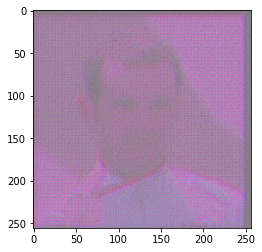

In [ ]:
predicted = tf.squeeze(predicted, axis=0)

predicted = np.array(predicted) * 255
predicted = predicted.astype(np.uint8)
# predicted = tf.image.adjust_contrast(predicted, )

plt.imshow(predicted)

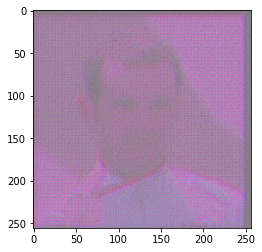

In [ ]:
# predicted = tf.squeeze(predicted, axis=0)

# predicted = np.array(predicted) * 255
predicted = cv2.cvtColor(predicted, cv2.COLOR_BGR2RGB)
plt.imshow(predicted)

In [ ]:
predicted.shape

(256, 256, 3)

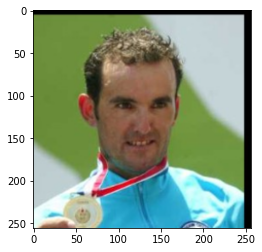

In [ ]:

test_img_path = test_filenames[1]
test_img = cv2.imread(test_img_path)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
test_img = cv2.resize(test_img, (WIDTH, HEIGHT))
plt.imshow(test_img)


In [ ]:
model = tf.keras.models.load_model('/content/FaceUnetDenoising.h5')

In [ ]:
path = '/content/Abbas_Kiarostami_0001.jpg'

img = cv2.imread(path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (256, 256))
img = random_noise(img, mode = 'gaussian')
# eval_set.append(img)
img = tf.expand_dims(img, axis=0)
predicted = model.predict(img)

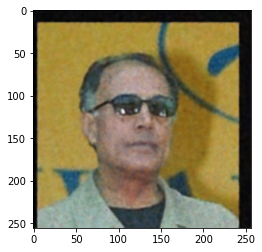

In [ ]:
predicted = tf.squeeze(predicted)
# predicted = cv2.cvtColor(predicted, cv2.COLOR_BGR2RGB)
plt.imshow(predicted)

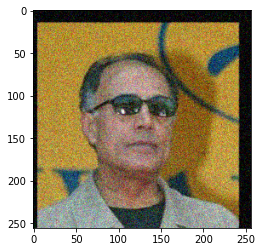

In [ ]:
img = tf.squeeze(img)

plt.imshow(img)

Text(0.5, 1.0, 'Noisy Image')

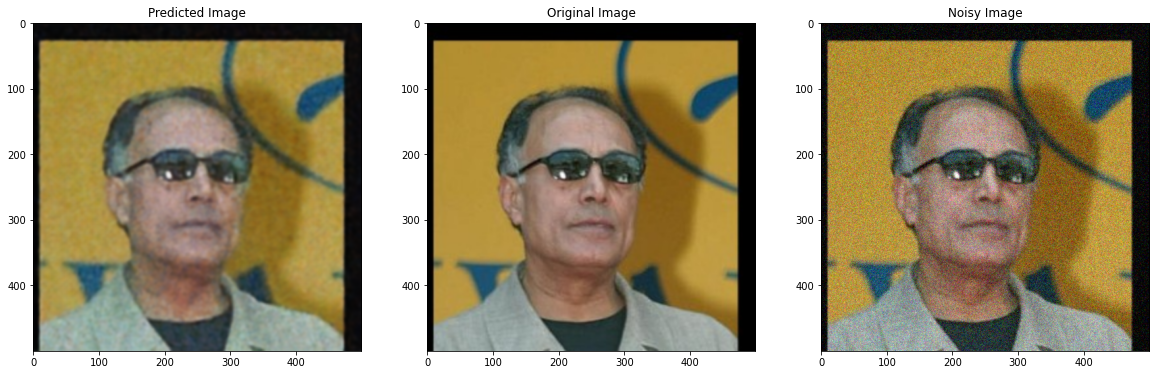

In [ ]:
# for j in range(3):
predicted = np.array(predicted)
predicted = cv2.resize(predicted, (500,500))
predicted = cv2.cvtColor(predicted, cv2.COLOR_BGR2RGB)
fig, ax = plt.subplots(1,3, figsize = (20,20))
original = cv2.imread(path)
original = cv2.resize(original, (500, 500))
original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
noisy_orig = random_noise(originalmode = 's&p', amount=0.2)
noisy_orig = cv2.resize(noisy_orig, (500,500))
ax[0].imshow(predicted)
ax[0].set_title('Predicted Image')
ax[1].imshow(original)
ax[1].set_title('Original Image')
ax[2].imshow(noisy_orig)
ax[2].set_title('Noisy Image')
